<a href="https://colab.research.google.com/github/sakshamgarg/Augmenting-Dirichlet-Network/blob/main/Resnet_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
from mpl_toolkits import mplot3d
from torch.distributions.dirichlet import Dirichlet

from scipy.stats import multivariate_normal
from scipy.stats import norm

import torchvision
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from scipy.stats import multivariate_normal
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib import cm
import sys

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CV_Project


Mounted at /content/drive
/content/drive/My Drive/CV_Project


In [ ]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)                                             
cifar_transform =  transforms.Compose(
      [transforms.ToTensor(),
     transforms.Normalize(cifar_mean, cifar_std)])

In [ ]:
test_in_full = torchvision.datasets.CIFAR10('./files/', train=False, download=True,
                                        transform=cifar_transform)
test_out_full = torchvision.datasets.SVHN('./data', split ='test', download=True,
                                        transform=cifar_transform)

Files already downloaded and verified
Using downloaded and verified file: ./data/test_32x32.mat


In [ ]:
test_out_full.targets = torch.tensor(np.ones(len(test_out_full.labels))*10, dtype=torch.long)

In [ ]:
test_in_cut = test_in_full
test_out_cut = test_out_full

In [ ]:
test_in_cut.data = test_in_full.data[0:1000]
test_in_cut.targets = test_in_full.targets[0:1000]
test_out_cut.data = test_out_full.data[0:1000]
test_out_cut.targets = test_out_full.labels[0:1000]
test_in = test_in_cut
test_out = test_out_cut

In [ ]:
# import torch
import torch.nn as nn
import os

__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
]


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=10,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        replace_stride_with_dilation=None,
        norm_layer=None,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                "or a 3-element tuple, got {}".format(replace_stride_with_dilation)
            )
        self.groups = groups
        self.base_width = width_per_group

        # CIFAR10: kernel_size 7 -> 3, stride 2 -> 1, padding 3->1
        self.conv1 = nn.Conv2d(
            3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False
        )
        # END

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(
            block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0]
        )
        self.layer3 = self._make_layer(
            block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1]
        )
        self.layer4 = self._make_layer(
            block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2]
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, device, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        script_dir = os.path.dirname(__file__)
        state_dict = torch.load(
            script_dir + "/state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, device, **kwargs
    )


def resnet34(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet34", BasicBlock, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )


def resnet50(pretrained=False, progress=True, device="cpu", **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet(
        "resnet50", Bottleneck, [3, 4, 6, 3], pretrained, progress, device, **kwargs
    )

In [ ]:
def get_resnet_output(data,model):

  y = model.forward(data)

  y = torch.nn.functional.softmax(5*y, dim = 1)

  return y

In [ ]:
def get_resnet_features(data, model):
  
      x = model.conv1(data)
      x = model.bn1(x)
      x = model.relu(x)
      x = model.maxpool(x)

      x = model.layer1(x)
      x = model.layer2(x)
      x = model.layer3(x)
      x = model.layer4(x)

      x = model.avgpool(x)
      x = x.reshape(x.size(0), -1)

      return x

In [ ]:
model = resnet18()
model.load_state_dict(torch.load('resnet18.pt'))
model = model.to(device)

In [ ]:
class PriorNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)         # output_dim = 4

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x #F.softmax(x, dim=1)

    def predict_alpha(self, x):
      src = torch.Tensor(x).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))
    
    def expected_entropy_from_alphas(self, alphas, alpha0):
        return -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
    
    def categorical_entropy_torch(self, probs):
        log_probs = torch.log(probs)
        log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
        entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
        return entropy

    def mutual_information(self, x):
        
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0

        expected_entropy = self.expected_entropy_from_alphas(alphas, alpha0)
        entropy_of_exp = self.categorical_entropy_torch(probs)
        mutual_info = entropy_of_exp - expected_entropy
        return mutual_info

    def diffenrential_entropy(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

    def entropy(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        ret = -torch.sum(probs*torch.log(probs), dim=1)
        return ret

In [ ]:

augnet_path =  'augnet'
file_name = 'augnet_res'
from os import truncate

class AugNet(PriorNet):

    def __init__(self, old_preds_dim, feature_dim, target_dim):
        super().__init__()
#         self.y_dim = old_preds_dim
#         self.feature_dim = feature_dim
#         self.target_dim = target_dim
#         self.fc1 = nn.Linear(feature_dim, 256)   
#         self.relu = torch.nn.ReLU()
#         self.fc2 = nn.Linear(256, 128)       
#         self.fc3 = nn.Linear(128, 50) 
#         self.fc4 = nn.Linear(50 + self.y_dim ,32) # concat # 50 + 10
#         self.fc5 = nn.Linear(32,10)
        self.y_dim = old_preds_dim
        self.feature_dim = feature_dim
        self.target_dim = target_dim
        self.fc1 = nn.Linear(feature_dim, 256)   
        self.relu = torch.nn.ReLU()
        self.fc2 = nn.Linear(256, 128)       
        self.fc3 = nn.Linear(128, 50) 
        self.fc4 = nn.Linear(50 + self.y_dim , 1024) # concat # 50 + 10
        self.fc5 = nn.Linear(1024, 256)
        self.fc6 = nn.Linear(256, 64)
        self.fc7 = nn.Linear(64, 10)

     
  

    def forward(self, features, y):

#       x = self.fc1(features)
#       x = self.relu(x)
#       x = self.fc2(x)
#       x = self.relu(x)
#       x = self.fc3(x)
#       # print("x")
#       # print(x.shape)
#       # print("y")
#       # print(y.shape)

#       x = self.fc4(torch.cat( (y,x), dim = 1) )
#       x = self.relu(x)
#       x = self.fc5(x)
      x = self.fc1(features)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      # print("x")
      # print(x.shape)
      # print("y")
      # print(y.shape)

      x = self.fc4(torch.cat( (y,x), dim = 1) )
      x = self.relu(x)
      x = self.fc5(x)
      x = self.relu(x)
      x = self.fc6(x)
      x = self.relu(x)
      x = self.fc7(x)
      return x



    def predict_alpha(self, x, model):
            x = torch.FloatTensor(x).unsqueeze(0) 
            x = x.to(device)
            x = x.reshape(-1, 3, 32, 32)
            features = get_resnet_features(x, model)
            pred_outputs = get_resnet_output(x, model)
#           src = torch.Tensor(x).to(device)
            output = torch.exp(self.forward(features, pred_outputs))
            return output
    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet
  
    def fit(self, epoch_num, optimizer, model):
      self.train()
      loss_track = []
      # Shuffle the input
      train_loader = torch.utils.data.DataLoader(train_all, batch_size=64)

      for epoch in range(epoch_num):


        loss_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):

          optimizer.zero_grad()

          #print(type(data))
          #print(data.shape)
          #break

        
         # data = data.to(device)
          target = target.to(device)

          #data = data.permute(0,3,1,2)
          #data= data.to(torch.float64)
          data= data.type(torch.FloatTensor).to(device)
          #x =x.unsqueeze(0)
          
          features = get_resnet_features(data,model)
          features = features.detach().requires_grad_(False)

          y = get_resnet_output(data,model)
          y = y.detach().requires_grad_(False)
  
          # predict alpha
          target_a = target_alpha(target)
          target_a = target_a.to(device)
          out = self.forward(features, y)
          output_alpha = torch.exp(out)

          dirichlet1 = Dirichlet(output_alpha)
          dirichlet2 = Dirichlet(target_a)
          lambdas = check_in_out_lambdas(target_a)
          sgm_alpha = torch.sigmoid(output_alpha) 


          loss = torch.sum(dist.kl.kl_divergence(dirichlet1, dirichlet2)  + lambdas * torch.mean(sgm_alpha,1))
          loss_total += loss.item()
          loss.backward(retain_graph=True)
          optimizer.step()

        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss_total/120000))
        loss_track.append(loss_total)

        if(epoch%10 == 0):
        
          torch.save({
              'epoch': epoch,
              'model_state_dict': self.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_track,
              }, f"{augnet_path}/{file_name+str(epoch)+'.pth'}")
        
      return loss_track
    
    def max_prob(self, x):
        alphas = self.predict_alpha(x, model)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        conf = torch.max(probs, dim=1)
        return conf.values

In [ ]:
dpn = AugNet(10,512,10)
dpn_model = torch.load('augnet/augnet_res20.pth')
dpn.load_state_dict(dpn_model['model_state_dict'])
dpn.to(device)

AugNet(
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu): ReLU()
  (fc3): Linear(in_features=128, out_features=50, bias=True)
  (fc4): Linear(in_features=60, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
# miscood.py

def uncertainty_score(dpn, test_data, metrics):
  dpn.eval()
  score_lst = []
  for x in test_data:
    with torch.no_grad():
      if metrics=='DE':
        score = dpn.diffenrential_entropy(x).data.cpu().numpy()[0][0]
      elif metrics=='MI':
        score = dpn.mutual_information(x).data.cpu().numpy()[0]
      elif metrics=='MAXP':
        score = dpn.max_prob(x).data.cpu().numpy()[0]
      elif metrics=='ENT':
        score = dpn.entropy(x).data.cpu().numpy()[0]
    score_lst.append(score)
  return score_lst


def get_ood_label_score(test_in_score, test_out_score):
  score = np.concatenate([test_in_score, test_out_score])
  label = np.concatenate((np.zeros(len(test_in_score)), np.ones(len(test_out_score))))
  return label, score
  
def get_misc_label_score(dpn, test_data, test_label, test_in_score):
  misc_label = np.zeros(len(test_label))

  for i in range(len(test_data)):
    x = test_data[i]
#     x = [x]
    with torch.no_grad():
      pred = dpn.predict_alpha(x, model)
      pred_class = torch.max(pred[0], 0).indices
      misc_label[i] = 1-torch.eq(torch.tensor(test_label[i]), pred_class).sum().cpu().numpy()

  return misc_label, np.array(test_in_score)

def plot_roc(label, score, label_name):
  fpr, tpr, thresholds = roc_curve(label, score)
  plt.plot(fpr, tpr, label=label_name)
  plt.xlabel('False Positive')
  plt.ylabel('True Positive')
  plt.title('ROC')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)

def plot_pr(label, score, label_name):
  precision, recall, thresholds = precision_recall_curve(label, score)
  plt.plot(recall, precision, label=label_name)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.ylim(0.0, 1.0)
  plt.xlim(0.0, 1.0)


def get_auroc_aupr(label, score):
  auroc = roc_auc_score(label, score)
  precision, recall, thresholds = precision_recall_curve(label, score)
  aupr = auc(recall, precision)
  return auroc, aupr


def get_test_roc_pr(network, metrics, detect='ood'):
  test_in_score = uncertainty_score(network, test_in.data, metrics)
  test_out_score = uncertainty_score(network, test_out.data, metrics)
  if detect=='ood':
    label_dp, score_dp = get_ood_label_score(test_in_score, test_out_score)
  elif detect=='misc':
    label_dp, score_dp = get_misc_label_score(network, test_in.data,
                                              test_in.targets, test_in_score)
  if metrics=='MAXP':
    score_dp = -score_dp

  index = np.isposinf(score_dp)
  score_dp[np.isposinf(score_dp)] = 1e9
  maximum = np.amax(score_dp)
  score_dp[np.isposinf(score_dp)] = maximum + 1

  index = np.isneginf(score_dp)
  score_dp[np.isneginf(score_dp)] = -1e9
  minimum = np.amin(score_dp)
  score_dp[np.isneginf(score_dp)] = minimum - 1

  score_dp[np.isnan(score_dp)] = 0

  auroc, aupr = get_auroc_aupr(label_dp, score_dp)
  return auroc, aupr, label_dp, score_dp

In [ ]:
auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

In [ ]:
auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.511419,0.523309,0.461365,0.518292
AUPR,0.899463,0.900643,0.884747,0.899529


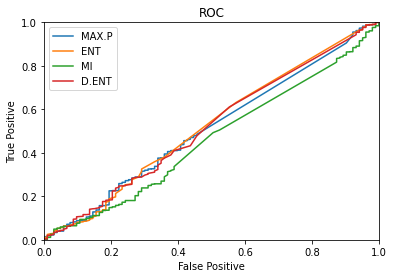

In [ ]:
plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

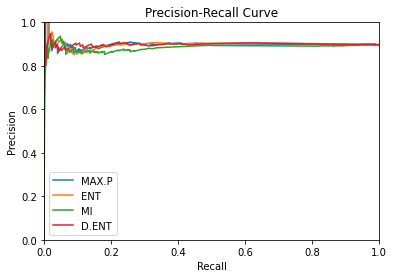

In [ ]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

In [ ]:
auroc_mp_ood, aupr_mp_ood, label_mp_ood, score_mp_ood = get_test_roc_pr(dpn, 'MAXP', 'ood')
auroc_ent_ood, aupr_ent_ood, label_ent_ood_ood, score_ent_ood = get_test_roc_pr(dpn, 'ENT', 'ood')
auroc_mi_ood, aupr_mi_ood_ood, label_mi_ood, score_mi_ood = get_test_roc_pr(dpn, 'MI', 'ood')
auroc_de_ood, aupr_de_ood, label_de_ood, score_de_ood = get_test_roc_pr(dpn, 'DE', 'ood')

In [ ]:
auroc_lst_ood = [auroc_mp_ood, auroc_ent_ood, auroc_mi_ood, auroc_de_ood]
aupr_lst_ood = [aupr_mp_ood, aupr_ent_ood, aupr_mi_ood_ood, aupr_de_ood]

pd.DataFrame(data=np.array([auroc_lst_ood, aupr_lst_ood]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.427155,0.432520,0.485359,0.428591
AUPR,0.439359,0.443831,0.474373,0.445547


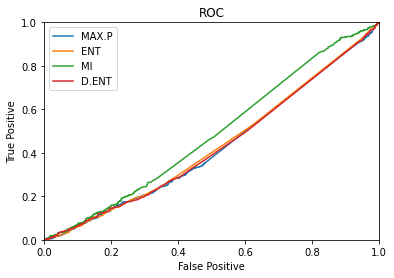

In [ ]:
plot_roc(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_roc(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_roc(label_mi_ood, score_mi_ood, label_name='MI')
plot_roc(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()

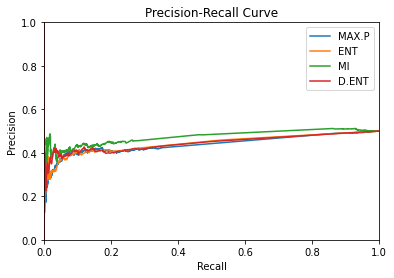

In [ ]:
plot_pr(label_mp_ood, score_mp_ood, label_name='MAX.P')
plot_pr(label_ent_ood_ood, score_ent_ood, label_name='ENT')
plot_pr(label_mi_ood, score_mi_ood, label_name='MI')
plot_pr(label_de_ood, score_de_ood, label_name='D.ENT')
plt.legend()
plt.show()